<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

## Time series pt. 3: mean smoothing, acf, pacf, and ARIMA

Week 9 | Lesson 3.1

---

We are continuing through time series examination, ending with the standard methods for analyzing them statistically.

Begin as usual by loading the packages.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import prettyplotlib as ppl

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from ipywidgets import interact
import ipywidgets as widgets

---

### Time series datasets

There are multiple datasets included here, with the code for parsing them included in the interest of time. However, *please review the code for munging time-related fields in pandas!*

The datasets are:

    The Rossman data 
        This is the dataset on store sales we looked at yesterday.
    Facebook stock price data
        Prices are by day.
    Netflix stock price data
        Also by day.
    HMNY stock prices
        Not sure what this company is. Pulled the data because it had high volatility
        and was intra-day rather than day-by-day. For simplicity however I have
        converted the intra-day prices to be as if they were days rather than 5-minute
        increments.
        
There is simulation data that will be loaded later, but I will discuss it at that point.

---

### Rossman data:

In [5]:
stores = pd.read_csv('./datasets/rossmann.csv', skipinitialspace=True)
stores.columns = ['store','day_of_week','date','sales','customers','open','promo',
                'state_holiday','school_holiday']

stores.date = pd.to_datetime(stores.date)

stores.index = stores.date
stores.sort_index(ascending=True, inplace=True)

store = stores[stores.store == 1]
store = store[['date','sales','open']]
store.columns = ['date','quantity','open']

/Users/sebozek/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


---

### Facebook stock data:

In [6]:
facebook = pd.read_csv('./datasets/WIKI-FB.csv')
facebook = facebook[['Date','Open']]
facebook.columns = ['date','quantity']

facebook.date = pd.to_datetime(facebook.date)
facebook.index = facebook.date
facebook.sort_index(ascending=True, inplace=True)

---

### Netflix stock data

In [7]:
netflix = pd.read_csv('./datasets/WIKI-NFLX.csv')
netflix = netflix[['Date','Open']]
netflix.columns = ['date','quantity']

netflix.date = pd.to_datetime(netflix.date)
netflix.index = netflix.date
netflix.sort_index(ascending=True, inplace=True)

---

### HMNY intraday

Originally 5 or maybe 10 minute increments over 3 days, but switched to be as if it were day-by-day to match up with the other stock prices.

In [8]:
hmny = pd.read_csv('./datasets/HMNY_3d.csv')

hmny['minutes'] = np.arange(hmny.shape[0])
hmny['date'] = hmny.minutes.map(lambda x: dt.datetime(2014,1,1)+dt.timedelta(x))
hmny.index = hmny.date
hmny.sort_index(ascending=True, inplace=True)

hmny = hmny[['CLOSE','date']]
hmny.columns = ['quantity','date']

---

### Set the selected dataset to the `data` variable for use in interactive plots

The interactive plots I've designed below just accept the **`data`** variable. This is for convenience since you can switch out the dataset you're interested in to the data variable and not have to change any code below!

There is also a **`static_noise`** variable that is essentially normally distributed noise in the shape of the dataset you selected. This is to increase noise in the interactive plots to see how it affects the statistics.

In [13]:
# assign data variable:
data = netflix

# set up noise too:
static_noise = np.random.normal(loc=0, scale=1, size=data.shape[0])

---

### Interactive plotting of windowed mean estimators over data

This is an interactive chart that lets you look at two ways of smoothing out means over time series data:

- **rolling means** move a window across the data, only using those data points within the window to calculate the mean.
    - The larger the window, the smoother the mean is (more resistant to noise and less complex - higher bias!)
- **exponentially weighted means** have a specified "decay" that weights previous means less and less as the distance from the current timepoint increases.
    - This is generally considered superior to the rolling mean. You still specify a window to limit the points calculated for the weighted mean.
    
---

### Definition of exponentially weighted windows

The mathematical formula for the exponentially weighted mean over a timeseries is:


### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

Where we are calculating the weighted mean for $x_t$ from previous timepoints (where $x$ variables are values at timepoints).

It is often referred to as "exponential decay" because each subsequent prior mean has an exponential decrease in contribution to the estimation of the current mean.

---

In [14]:
def plot_mean_estimator(sd, resample='D', window=4, orig_resample='D',
                        meantype='rolling'):
    
    plt.figure(figsize=(18,7))
        
    orig_quant = sd.quantity.resample(orig_resample).mean()
    orig_dates = orig_quant.index.to_pydatetime()
    
    plt.plot(orig_dates, orig_quant, lw=2, c='black', ls='dashed', alpha=0.35, label='original')
    
    if meantype == 'rolling':
        est_quant = sd.quantity.resample(resample).mean().rolling(window=window).mean()
    elif meantype == 'expweight':
        est_quant = sd.quantity.resample(resample).mean().ewm(span=window).mean()
        
    est_dates = est_quant.index.to_pydatetime()
    
    plt.plot(est_dates, est_quant, lw=3.5, label='mean estimate')

    plt.tick_params(labelsize=14)
    plt.legend(loc='upper left')

    plt.show()
    

In [15]:
def estmean_wrapper(timemin=0, timemax=50, resample='D', window=2, meantype='rolling',
                    artificial_noise=0):
    
    sd = data.iloc[timemin:timemax, :].copy()
    noise = static_noise[timemin:timemax] * artificial_noise
    sd.loc[:, 'quantity'] += noise
    
    plot_mean_estimator(sd, resample=resample, window=window, 
                        orig_resample=resample, meantype=meantype)
    

timeminw = widgets.IntSlider(min=0, max=data.shape[0]-2, step=1, value=0, continuous_update=False)
timemaxw = widgets.IntSlider(min=1, max=data.shape[0]-1, step=1, value=data.shape[0]-1, continuous_update=False)
windower = widgets.IntSlider(min=1, max=10, step=1, value=2, continuous_update=False)
resample_opts = {'days':'D', 'weeks':'W', 'months':'M'}
meantype_opts = {'rolling mean':'rolling', 'exponentially weighted':'expweight'}
noiser = widgets.FloatSlider(min=0, max=10, step=0.25, value=0, continuous_update=False)

def update_timemax(*args):
    timemaxw.min = timeminw.value + 1
    
timeminw.observe(update_timemax, 'value')



---

### Mean plotting variables

There are multiple variables you can adjust when looking at your timeseries data of choice:

    meantype         : this is either going to be the rolling mean or 
                       exponential decay
    resample         : this is the window over which you will be doing 
                       the mean smoothing (day, week, month)
    window           : this specifies the size of the window - longer 
                       windows mean more smoothing
    timemin          : timemin lets you adjust the window of the dataset's
                       time series you are looking at
    timemax          : corresponding window limiter to timemin. combined 
                       they control the window of the chart.
    artificial_noise : you can optionally add noise to the timeseries to 
                       see how it affects mean smoothing.

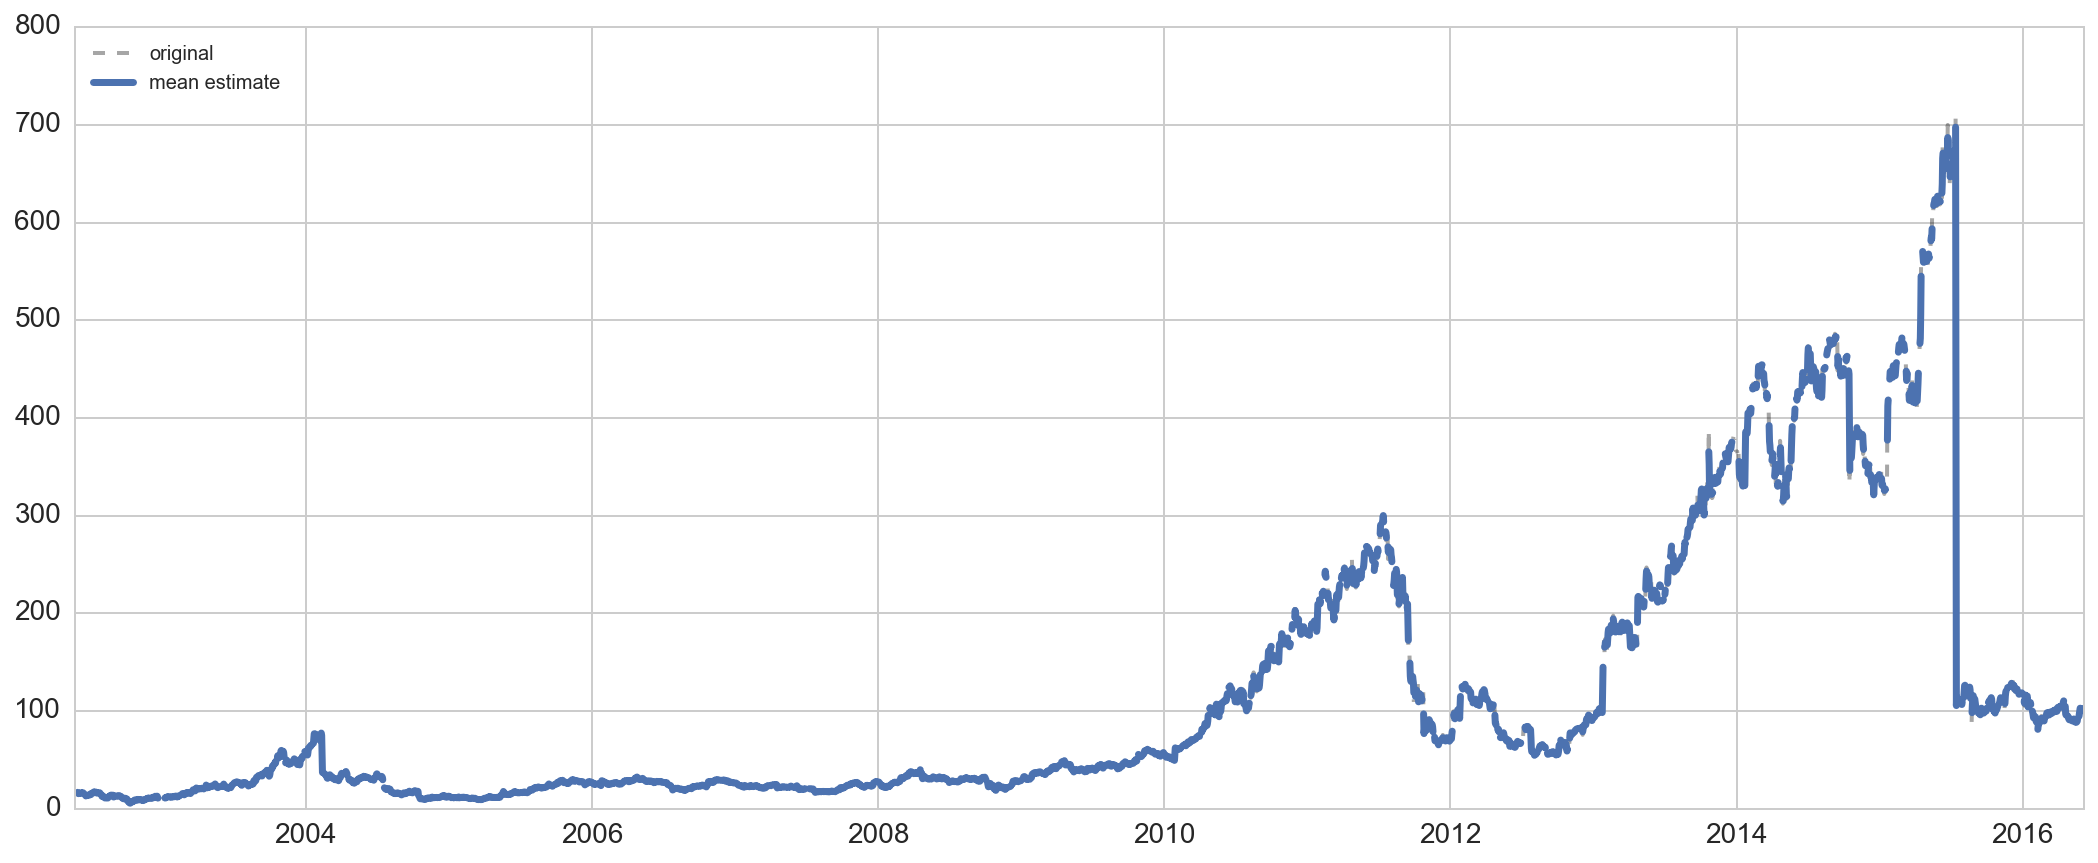

<function __main__.estmean_wrapper>

In [16]:
interact(estmean_wrapper,
         meantype=meantype_opts,
         resample=resample_opts,
         window=windower,
         timemin=timeminw, 
         timemax=timemaxw,
         artificial_noise=noiser)

---

### The autocorrelation function (acf) and partial autocorrelation function (pacf)

Autocorrelation and partial autocorrelation are useful numerical measures to quantify properties of a timeseries.

---

**AUTOCORRELATION**

The correlation of a timeseries *to itself shifted by a specific lag.*

- At lag = 3, for example, we would move the entire timeseries backwards by 3 and correlate the two timeseries with each other.
- What does this tell us? In a nutshell, autocorrelation shows us how affected the value of a timepoint is by the timepoints prior. In the sales data, for example, we have a very high autocorrelation when we lag days by 7. Why? Because quantity of sales on Saturdays, for example, are most correlated with the quantities of sales on other Saturdays.

To review the formulas from yesterday:

Below is the formula for the autocorrelation funtion (acf):

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ at time points } t_1, t_2, t_3 ... t_n:$

### $$lag_k\;acf() = \frac{\sum_{i=1}^{n-k}\left(\left(\;x_i - \bar{x}\;\right)\left(\;x_{i+k} - \bar{x}\;\right)\right)}{\sum_{i=1}^n\left(\;x_i - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ aand measurements } y_1, y_2, y_3 ... y_n:$

### $$r_{xy} = \frac{\sum_{i=1}^{n-k}\left(\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$

When you do a normal correlation between two variables, you are inputting the two variables' vectors into the function. This is the same for autocorrelation, but the second variable is simply a lagged version of the first.

---

**PARTIAL AUTOCORRELATION** 

This is a more difficult concept, but an essential sister metric to the autocorrelation. Partial autocorrelation measures the correlation between shifted timeseries like autocorrelation does, *but controls for the effect of lower order lags on that correlation.*

Yes, confusing. But hopefully we will clear it up.

The partial autocorrelation function (pacf) is similar to the autocorrelation function (acf); the difference is that the correlations between the earlier (lower order) lagged timepoints are "regressed out" of the correlation for the lag of interest.

I think putting it in the context of regression is the most intuitive way to think about this.

Imagine we are interested in the partial autocorrelation of a timeseries with lag = 2. Remember, this means we are shifting the timeseries back by two and comparing it to the original to see how correlated the shift is to the original. If we were to stop there we would have autocorrelation.

However, in partial autocorrelation we do not want the effect of lags leading up to this influencing the correlation. Put another way, if the lag 1 timeseries is correlated with our timepoint, lag 2 is more likely to be correlated, as is lag 3, etc. Our correlations from the other lags can "seep into" the correlation for the current lag. 

Ok, in this regression example we are interested in lag = 2. Set up two regressions:

**Regression 1 $lm_{t-1}$:** predict our current timeseries denoted by $x_{t}$ with a regression that includes an intercept as well as the *lagged by one timeseries* $x_{t-1}$. If these are autocorrelated, then $x_{t-1}$ will be a good predictor of $x_{t}$.

### $$lm_{t-1} = x_{t} \sim \beta_0 + \beta_1x_{t-1}$$

**Regression 2 $lm_{t-2}$:** predict our current timeseries $x_{t}$ now using a regression that includes an intercept, the lag-1 timeseries $x_{t-1}$, as well as the lag-2 timeseries $x_{t-2}$.

### $$lm_{t-2} = x_{t} \sim \beta_0 + \beta_1x_{t-1} + \beta_2x_{t-2}$$

The lag-2 partial autocorrelation $pacf(\;x_{t-2}\;)$ is **the variance explained by the second regression that has not been explained by the first lag-1 regression.**

If you are interesteed, the the $pacf$ is more formally defined as:

### $$ pacf \left( x_{t-n} \right) = \frac{covariance \left( x_{t}, \; x_{t-n} \; | \; x_{t-1} ... x_{t-n-1} \right)} {\sqrt {\;  variance \left( x_{t} \ ;| \; x_{t-1} ... x_{t-n-1} \right) variance \left( x_{t-n} \; | \; x_{t-1} ... x_{t-n-1} \right) \; } }$$

In [17]:
# statsmodels has convenient fucntions for calculating and nicely plotting these:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

---

### Simulation data

I created a bunch of simulation data in R that is generated to have different profiles on the $acf()$ and $pacf()$ charts.

These are actually backwards-generated from ARIMAs. Don't worry about that now, but the variables you specify for the interactive chart will serve as a good introduction to how ARIMA works:


In [18]:
sims = pd.read_csv('./datasets/arima_simulations.csv')
sims['date'] = sims.x_point.map(lambda x: dt.datetime(2014,1,1) + dt.timedelta(x))
sims.index = sims.date
sims.sort_index(ascending=True, inplace=True)

In [19]:
def plot_acf_pacf(sd):
    
    plt.figure(figsize=(18,14))
    
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(223)
    ax3 = plt.subplot(224)
    
    ax1.plot(sd.date, sd.quantity, lw=2.5, c='black')
    
    plot_acf(sd.quantity, lags=30, ax=ax2)
    plot_pacf(sd.quantity, lags=30, ax=ax3)
    plt.show()
    

In [20]:
def acf_pacf_wrapper(ar=0, diff=0, ma=0, sample=1):
    mask = (sims.iter == sample) & (sims.ar == ar) & (sims.i == diff) & (sims.ma == ma)
    sim = sims[mask]
        
    plot_acf_pacf(sim)

    
ars = widgets.IntSlider(min=0, max=3, step=1, value=1, continuous_update=False)
diffs = widgets.IntSlider(min=0, max=1, step=1, value=0, continuous_update=False)
mas = widgets.IntSlider(min=0, max=3, step=1, value=0, continuous_update=False)
sampler = widgets.IntSlider(min=1, max=5, step=1, value=1, continuous_update=False)

---

### acf and pacf simulation timeseries variables

**ar** : This is the *autoregressive order* of the timeseries. A higher number indicates that more autocorrelation lags explain the timeseries better.

**diff** : This is the differencing component (the I in ARIMA). Differencing in ARIMA allows the model to be fit without first converting a timeseries into the differences between timepoint values rather than the values itself (since the models only work correctly after removing general trends). In this interactive plot, you may choose zero or one. A one indicates that the timeseries would require this differencing procedure to be properly modeled.

**ma** : This is the *moving average order*. Higher numbers mean that the series of points *is better explained by the previous errors from the estimated mean.* What does this mean? Essentially spikes or fast changes in the timeseries are a more important component for predicting the future mean values.

**sample** : Each combination of ar, diff, and ma have 5 different timeseries that you can look through.

The timeseries will be plotted as well as the `acf` and `pacf` charts below it.


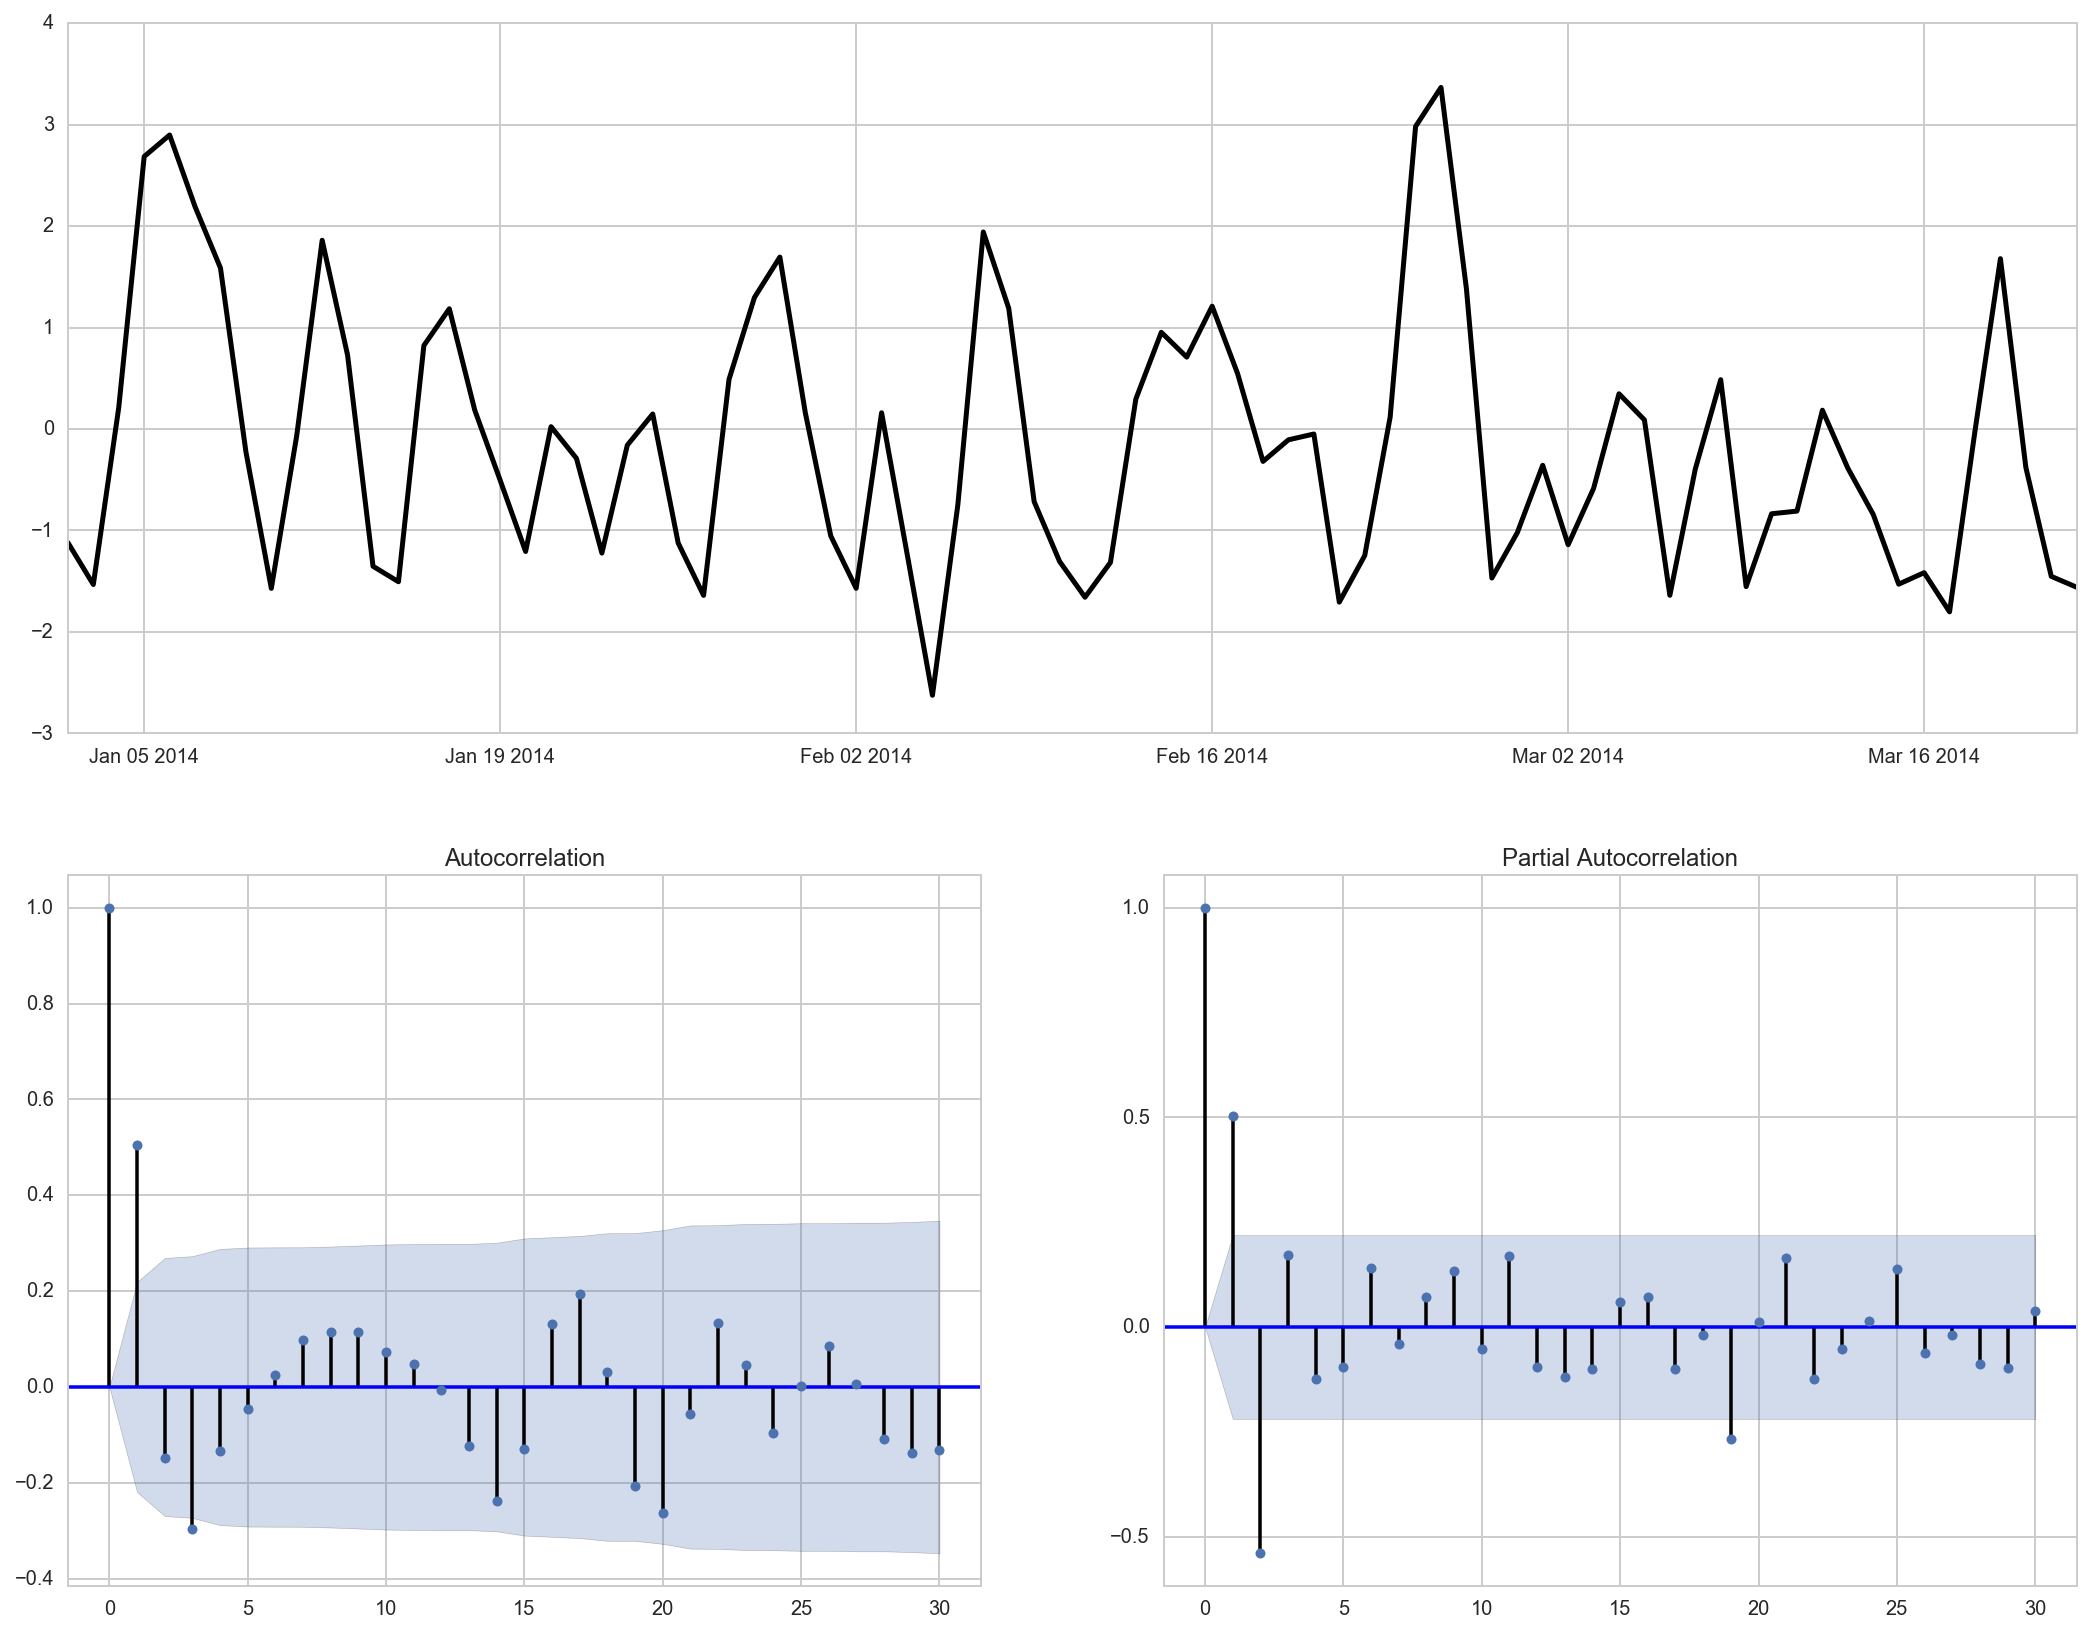

In [21]:
interact(acf_pacf_wrapper,
         ar=ars,
         diff=diffs,
         ma=mas,
         sample=sampler)

Here is some information on determining how to set up your ARIMA model based on what you can glean from the `acf` and `pacf` charts. Important reading!

https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins#Identify_p_and_q

---

### Building ARIMA models for the HMNY stock price data

To give examples of different kinds of ARIMA models I will be using a (somewhat modified) version of the HMNY stock data.

In the first cell below I add some extra noise to the stock prices to make them a bit messier. Some of the noise has big spikes, which I am hoping will make the moving average component of the model more important.


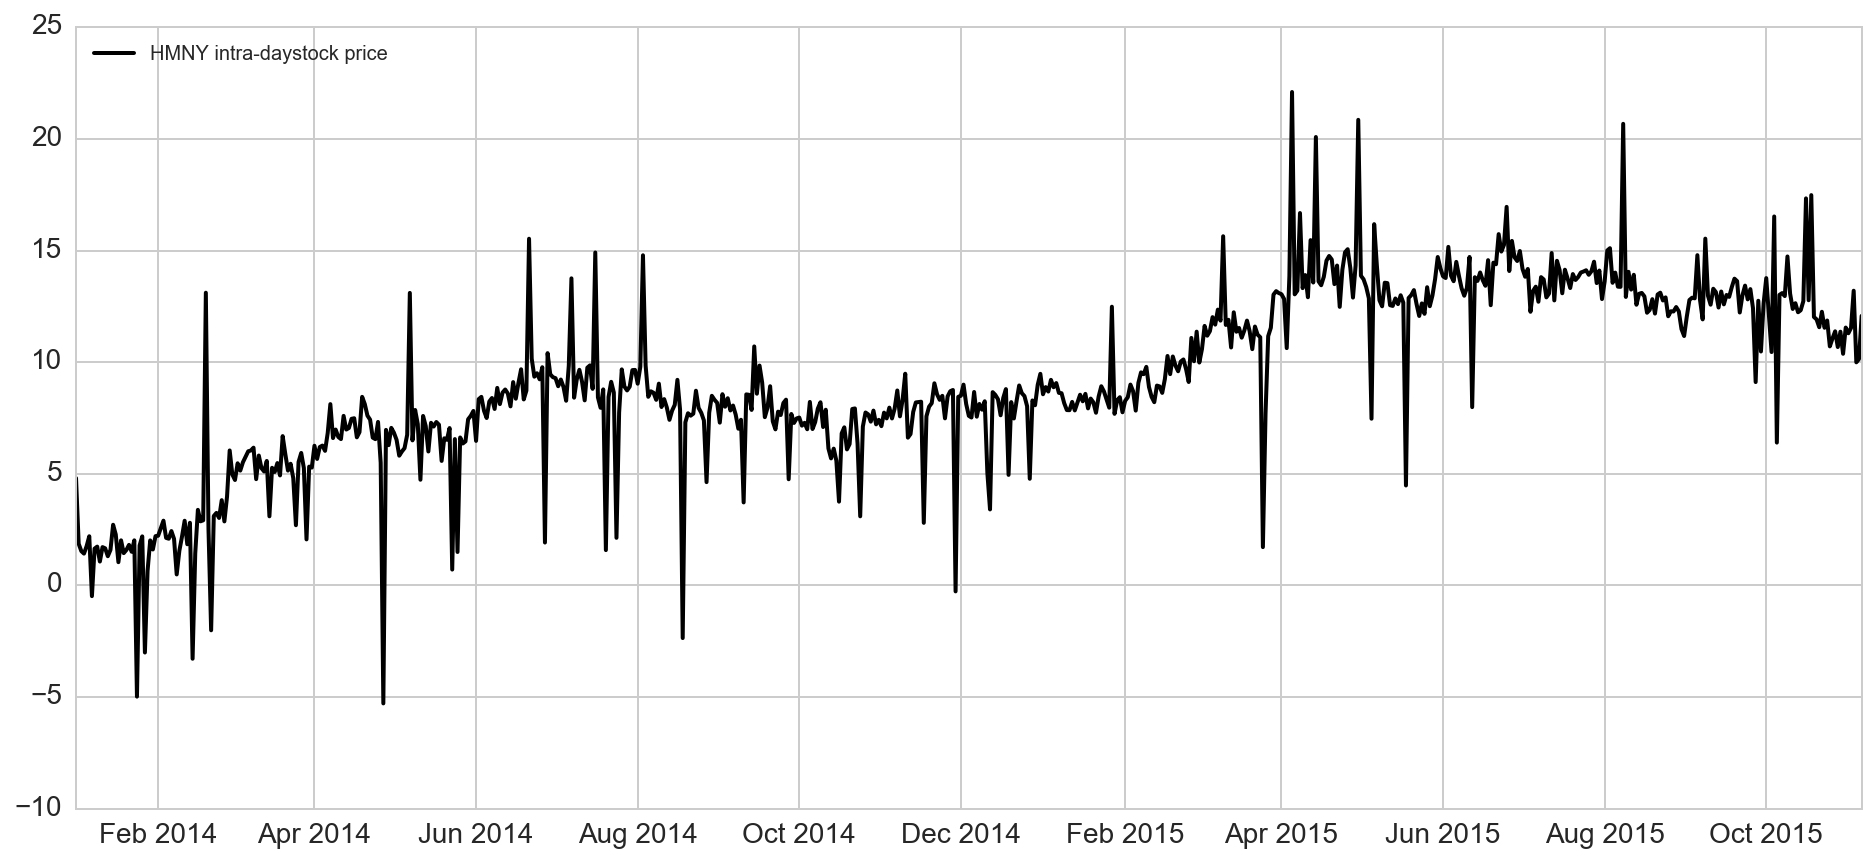

In [24]:
index_dates = hmny.index.to_pydatetime()

noise_stds = np.random.choice([0.5, 4.5],  size = len(index_dates), replace=True, p=[0.85,0.15])
hmny_price_noise = hmny.quantity.astype(float) + np.array([np.random.normal(0,sd) for sd in noise_stds])

fig = plt.figure(figsize=(16,7))

plt.plot(index_dates, hmny_price_noise, lw=2, c='black', alpha=1.0, label='HMNY intra-daystock price')

plt.tick_params(labelsize=14)
plt.legend(loc='upper left')

plt.show()

---

### Differencing the data

If we are *not* going to add a differencing component to the ARIMA model (by setting I = 0), then we should manually difference the data ourselves. AR, MA, ARMA, and ARIMA with I=0 expect that the "general" trends have been removed.

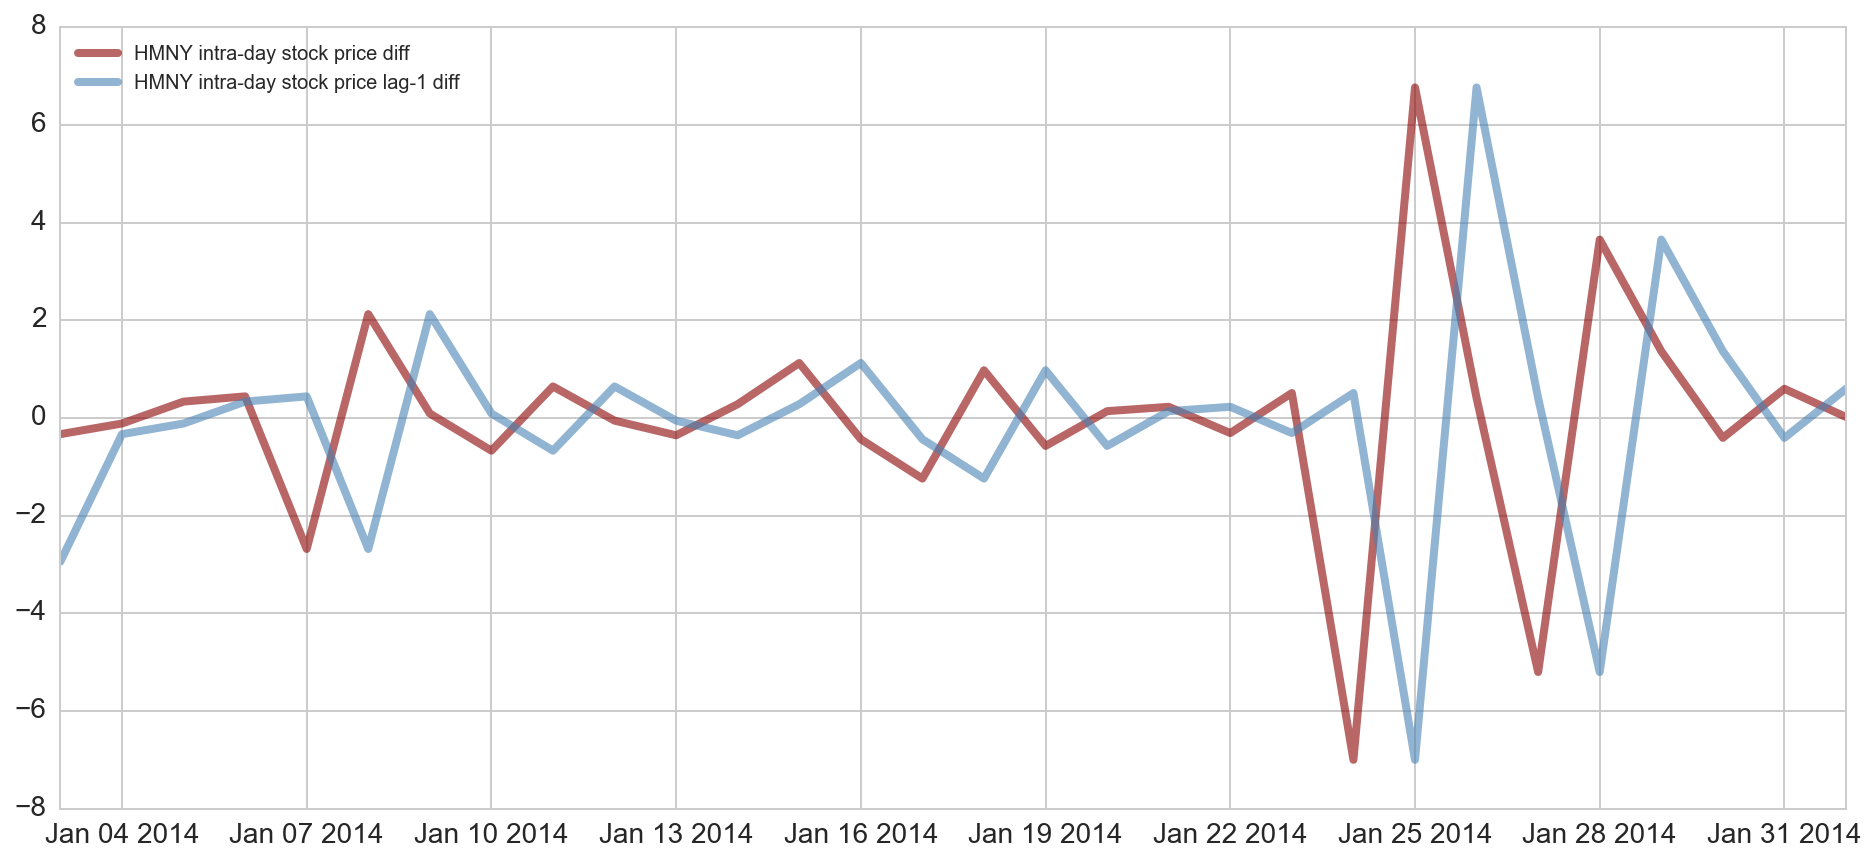

In [27]:
fig = plt.figure(figsize=(16,7))

hmny_price_noise_d = np.diff(hmny_price_noise)

plt.plot(index_dates[2:32], hmny_price_noise_d[1:31], lw=4,
        c='darkred', alpha = 0.6, label='HMNY intra-day stock price diff')

plt.plot(index_dates[2:32], hmny_price_noise_d[0:30], lw=4,
        c='steelblue', alpha=0.6, label='HMNY intra-day stock price lag-1 diff')

plt.tick_params(labelsize=14)
plt.legend(loc='upper left')

plt.show()

---

### acf and pacf of differenced data

Look at the acf and pacf of the differenced stock price data. We can see that the autocorrelation slowly decreases over lags, indicating that the timeseries has very high and consistent autocorrelation across lags. In other words, the movements of the timeseries are very related to/affected by the movements of previous time points.

On the other hand, the pacf shows that only a couple of early lags have a significant partial autocorrelation. Remember that the partial autocorrelation controls for earlier lags. This indicates (unsurprisingly, given the acf plot), that the correlations of lags beyond the first couple lags do not account for any more significant variance *in the prediction of the current time timeseries.* The autocorrelation of the first lag is just "passed along" the lags without adding additional information useful to prediction.

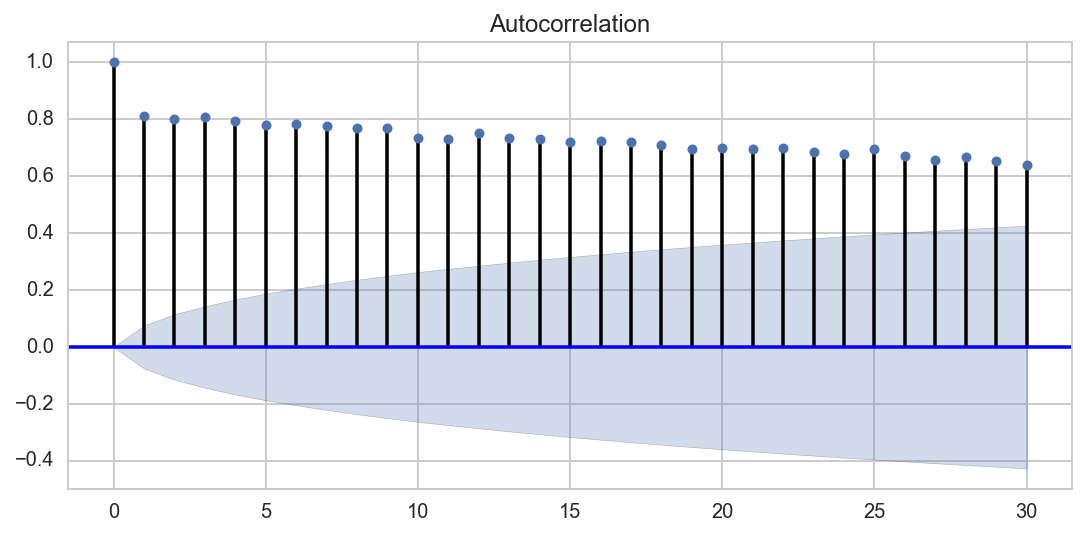

In [28]:
fig = plt.figure(figsize=(9,4))
ax = fig.gca()
plot_acf(hmny_price_noise, lags=30, ax=ax)
plt.show()

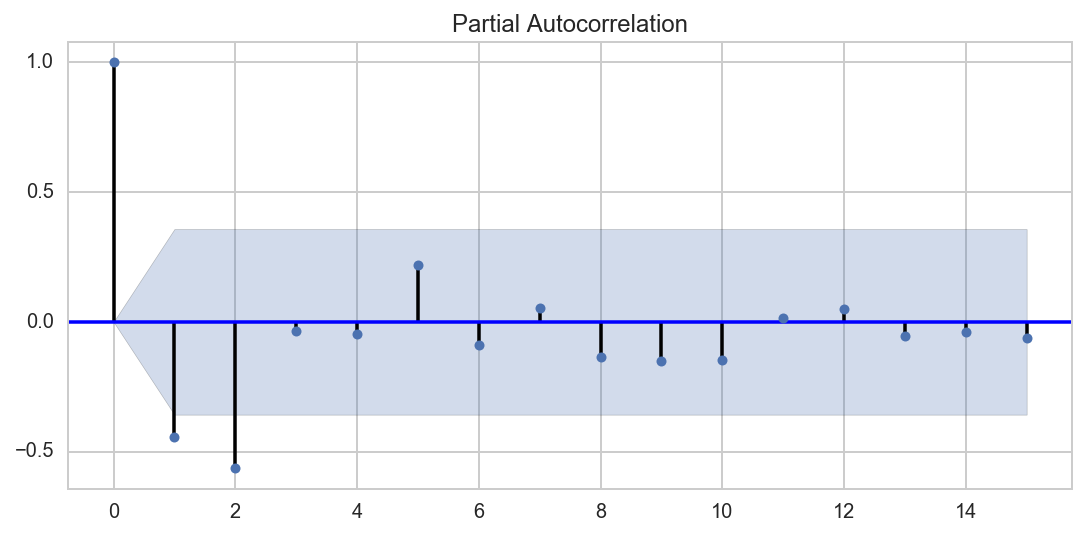

In [26]:
fig = plt.figure(figsize=(9,4))
ax = fig.gca()
plot_pacf(hmny_price_noise_d[0:30], lags=15, ax=ax)
plt.show()

---

### Construct AR=1 model

We will first construct a model on the differenced noise data using an AR=1 component. This means that we are going to model the timeseries using the lag-1 timeseries to make predictions.

Our model summary shows that the lag-1 predictor is very significant.

In [33]:
from statsmodels.tsa.arima_model import ARMA

hmny_model_ar1 = ARMA(hmny_price_noise_d, (5,0)).fit()
print hmny_model_ar1.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  674
Model:                     ARMA(5, 0)   Log Likelihood               -1385.365
Method:                       css-mle   S.D. of innovations              1.889
Date:                Wed, 08 Jun 2016   AIC                           2784.730
Time:                        14:51:03   BIC                           2816.323
Sample:                             0   HQIC                          2796.964
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0128      0.023      0.564      0.573        -0.032     0.057
ar.L1.y       -0.7713      0.038    -20.260      0.000        -0.846    -0.697
ar.L2.y       -0.6141      0.047    -12.984      0.0

We can also plot the residuals against the original differenced timeseries. You can see that the residuals still have a lot of variance that we didn't account for, but the variance has at least shrunk, which indicates our model is accounting for *something* in the timeseries.

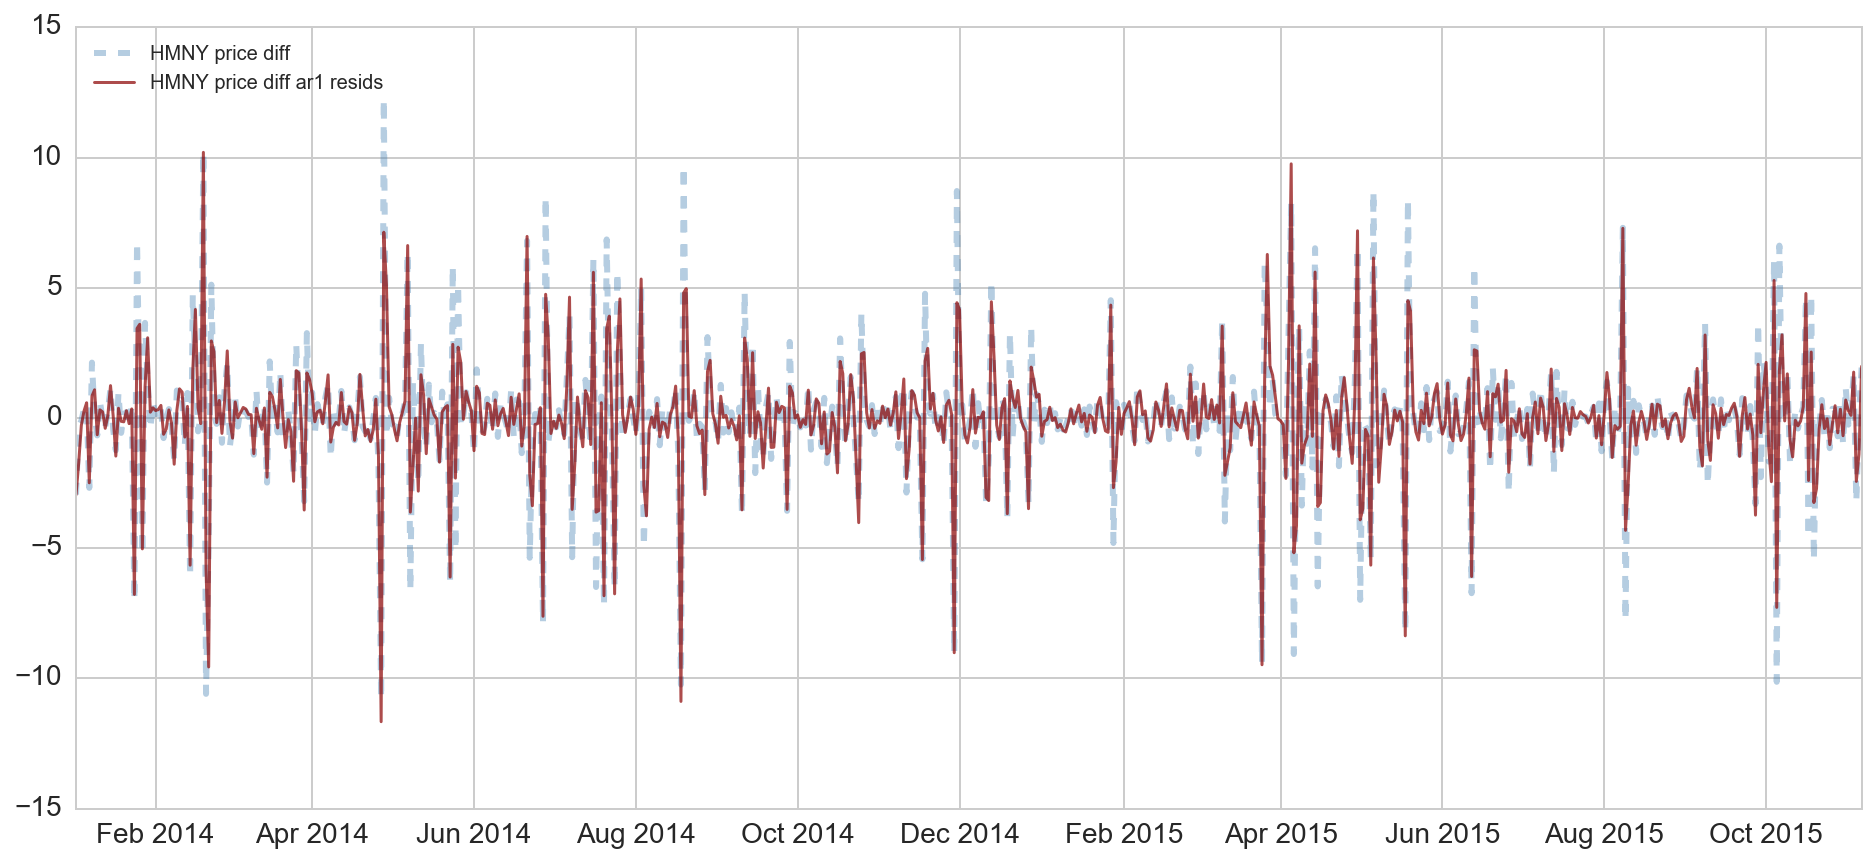

In [31]:
plt.figure(figsize=(16,7))

plt.plot(index_dates[1:], hmny_price_noise_d, lw=3, c='steelblue',
        alpha=0.4, ls='dashed', label='HMNY price diff')

plt.plot(index_dates[1:], hmny_model_ar1.resid, lw=1.5, c='darkred',
        alpha=0.7, label='HMNY price diff ar1 resids')

plt.tick_params(labelsize=14)
plt.legend(loc='upper left')
plt.show()

---

### Construct an ARMA model with AR=1 and MA=1

Now we'll make an ARMA model that combines an autoregressive component and a moving average component.

We can see from the result that the moving average component is far more significant (and has a higher coefficient) than the AR component. Interesting. This indicates that predicting the timeseries from prior *errors from the estimated mean* is more effective than predicting from the values of the prior timespoints themselves. 

When the MA component is more important, this usually indicates that quick burst events in the timeseries are occuring and important to prediction. This is likely due to the noise I added.

---

### acf and pacf of the model residuals

Ideally, the pacf and acf of the residuals from the model should be insignificant at lags (since we have purportedly accounted for that variance and used it in our prediction).

You can see below that there is still some signifcant effects in lagged residual values predicting current residuals, so the model is not perfect by any means.

In [ ]:
fig = plt.figure(figsize=(14,7))
ax = fig.gca()
plot_pacf(hmny_model_ar1.resid, lags=30, ax=ax)
plt.show()

---

### ARIMA with AR=2, I=1, MA=2

We can go for a more complex model and add two lags for both the AR and MA component. This is not necessarily a good thing as we are increasing variance while decreasing bias. As you know, it is important to find the best balance of both.

The I=1 differencing component indicates that we are predicting *future differences* rather than future values. This means, basically, that you don't have to do the differencing yourself prior to modeling.

How would we do that? Well, cross-validation isn't appropriate for timeseries data as the observations are not independent. You would need to test your model on held-out future data only.

The summary indicates that not all of our lag components are significant, but two seem to be at least marginally.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA


---

### Forecast with the model

You can actually forecast future values (with a confidence interval) using our ARIMA model. You could also do this with the models we fit before. It's pretty cool.

Below I plot the original timeseries, the residuals (centered on the x-axis due to the differencing) and the forecast for 300 future values of the timeseries.

You can also plot this out using statsmodels built in plotting functionality, though I think customizing the chart is much nicer as I did above if you are capable.